# Vanilla Generative Adversarial Network


In [1]:
import torch
import pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt

## Data

In [2]:
batch_size= 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

trainset = MNIST('./data/', train=True, transform=transform, download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

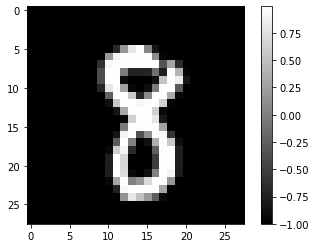

In [36]:
#Example: Normalized image. Values in [-1,1]
img, _ = next(iter(trainloader))

shw = plt.imshow(img[0].permute(1,2,0), cmap='gray')
plt.colorbar(shw)
plt.show()

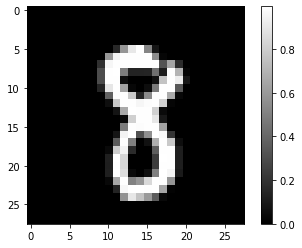

In [37]:
#Example: Denormalized image. Values in [0,1]
def denormalize(x):
    x = (x + 1) / 2
    return x

shw = plt.imshow(denormalize(img[0].permute(1,2,0)), cmap='gray')
plt.colorbar(shw)
plt.show()

## GAN

In [6]:
class Generator(nn.Module):
    def __init__(self, input_size=64, output_size=784, hidden_size=256):
        super().__init__()
        self.generator = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            #nn.BatchNorm1d(output_size),
            nn.ReLU(),
            
            nn.Linear(hidden_size, hidden_size),
            #nn.BatchNorm1d(output_size),
            nn.ReLU(),

            nn.Linear(hidden_size, output_size),
            nn.Tanh())

    def forward(self, x):
        return self.generator(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_size=784, hidden_size=256):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3),

            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3),
            
            nn.Linear(hidden_size, 1))
    
    def forward(self, x):
        return self.discriminator(x)

In [8]:
def noise_generator(batch_size, latent_size):
    return torch.randn(batch_size, latent_size).to(device)

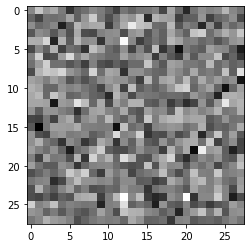

In [12]:
# Testing Generator
generator = Generator(input_size = 64, #latent_size
                      output_size = 784, #image_size
                      hidden_size = 256).to(device)

noise_vector = noise_generator(1, 64)
#noise_vector: [1, 64]
fake_img = generator(noise_vector)
#fake_img: [1, 784]
fake_img = denormalize(fake_img.detach().cpu().view(-1, 28, 28))
plt.imshow(fake_img[0], cmap='gray')
plt.show()

## Training

In [13]:
def train_discriminator(real_img, num_samples):
    #real_img: [batch_size, 784]

    discriminator.train()

    #Loss for real images
    pred_real =  discriminator(real_img)
    target_real = torch.ones_like(pred_real).to(device)
    d_loss_real = criterion(pred_real, target_real)

    #Loss for fake images
    noise_vector = noise_generator(num_samples, latent_size)
    fake_img = generator(noise_vector)
    pred_fake = discriminator(fake_img.detach())
    target_fake = torch.zeros_like(pred_fake)
    d_loss_fake = criterion(pred_fake, target_fake)

    d_loss = (d_loss_real + d_loss_fake)

    #Backprop and optimize
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss

In [ ]:
def train_generator(num_samples):
    generator.train()
    #Loss for fake images
    noise_vector = noise_generator(num_samples, latent_size)
    fake_img = generator(noise_vector)
    pred = discriminator(fake_img)
    target = torch.ones_like(pred).to(device)
    g_loss = criterion(pred, target)

    #Backprop and optimize
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    return g_loss

In [9]:
#Parameters and hyperparameters
epochs = 300
latent_size = 64
lr = 2e-4
hidden_size = 256
image_size = 784

In [10]:
generator = Generator(input_size = latent_size,
                      output_size = image_size,
                      hidden_size = hidden_size).to(device)
discriminator = Discriminator(input_size = image_size,
                              hidden_size = hidden_size).to(device)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr) #betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr) #betas=(0.5, 0.999))

criterion = nn.BCEWithLogitsLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import os

output_dir = 'outputs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

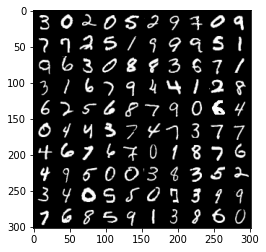

In [15]:
#Save some real images
from torchvision.utils import save_image

img, _ = next(iter(trainloader))
save_image(denormalize(img), os.path.join(output_dir, 'real_images.png'), nrow=10)

img = plt.imread(os.path.join(output_dir, 'real_images.png'))
plt.imshow(img, cmap='gray')
plt.show()

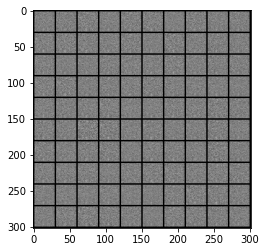

In [16]:
#Save fake images before training 
test_noise = noise_generator(batch_size, latent_size)

def save_fake_images(idx):
    fake_img = generator(test_noise)
    fake_img = denormalize(fake_img.detach().cpu().view(-1, 1, 28, 28))
    file_name = "fake_images-{0:0=4d}.png".format(idx)
    save_image(fake_img, os.path.join(output_dir, file_name), nrow=10)

save_fake_images(0)
img = plt.imread(os.path.join(output_dir, "fake_images-{0:0=4d}.png".format(0)))
plt.imshow(img, cmap='gray')
plt.show()

100%|██████████| 600/600 [00:16<00:00, 36.92it/s]


Epoch: 1/300, g_loss: 4.137905120849609, d_loss: 0.19266827404499054


100%|██████████| 600/600 [00:16<00:00, 35.75it/s]


Epoch: 2/300, g_loss: 4.8842387199401855, d_loss: 0.16275613009929657


100%|██████████| 600/600 [00:16<00:00, 36.49it/s]


Epoch: 3/300, g_loss: 4.262845516204834, d_loss: 0.33290180563926697


100%|██████████| 600/600 [00:16<00:00, 36.11it/s]


Epoch: 4/300, g_loss: 3.832866668701172, d_loss: 0.46401140093803406


100%|██████████| 600/600 [00:16<00:00, 36.51it/s]


Epoch: 5/300, g_loss: 3.3623950481414795, d_loss: 0.4633069932460785


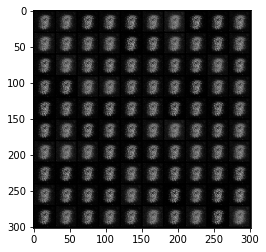

100%|██████████| 600/600 [00:16<00:00, 36.40it/s]


Epoch: 6/300, g_loss: 3.8591442108154297, d_loss: 0.20160801708698273


100%|██████████| 600/600 [00:16<00:00, 36.61it/s]


Epoch: 7/300, g_loss: 4.331417560577393, d_loss: 0.13254106044769287


100%|██████████| 600/600 [00:16<00:00, 36.24it/s]


Epoch: 8/300, g_loss: 5.013789176940918, d_loss: 0.1397935003042221


100%|██████████| 600/600 [00:16<00:00, 36.74it/s]


Epoch: 9/300, g_loss: 5.321132183074951, d_loss: 0.15229804813861847


100%|██████████| 600/600 [00:16<00:00, 36.50it/s]


Epoch: 10/300, g_loss: 5.829895973205566, d_loss: 0.14330337941646576


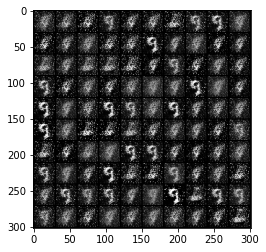

100%|██████████| 600/600 [00:16<00:00, 35.44it/s]


Epoch: 11/300, g_loss: 6.020118713378906, d_loss: 0.16731694340705872


100%|██████████| 600/600 [00:16<00:00, 36.09it/s]


Epoch: 12/300, g_loss: 5.305867671966553, d_loss: 0.193177729845047


100%|██████████| 600/600 [00:17<00:00, 35.26it/s]


Epoch: 13/300, g_loss: 4.946412086486816, d_loss: 0.17847669124603271


100%|██████████| 600/600 [00:16<00:00, 36.43it/s]


Epoch: 14/300, g_loss: 5.240396499633789, d_loss: 0.18886996805667877


100%|██████████| 600/600 [00:16<00:00, 36.46it/s]


Epoch: 15/300, g_loss: 4.641214847564697, d_loss: 0.1994805932044983


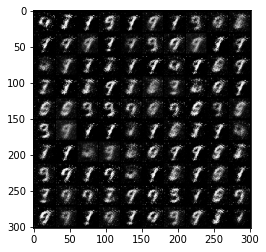

100%|██████████| 600/600 [00:16<00:00, 35.45it/s]


Epoch: 16/300, g_loss: 5.4684834480285645, d_loss: 0.158603698015213


100%|██████████| 600/600 [00:16<00:00, 36.14it/s]


Epoch: 17/300, g_loss: 7.026936054229736, d_loss: 0.16134659945964813


100%|██████████| 600/600 [00:16<00:00, 36.36it/s]


Epoch: 18/300, g_loss: 5.794471263885498, d_loss: 0.17975178360939026


100%|██████████| 600/600 [00:17<00:00, 33.54it/s]


Epoch: 19/300, g_loss: 5.726746082305908, d_loss: 0.22020383179187775


100%|██████████| 600/600 [00:17<00:00, 33.47it/s]


Epoch: 20/300, g_loss: 5.225893497467041, d_loss: 0.20248661935329437


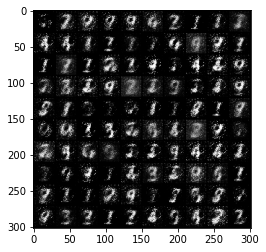

100%|██████████| 600/600 [00:19<00:00, 31.18it/s]


Epoch: 21/300, g_loss: 5.62835693359375, d_loss: 0.22608765959739685


100%|██████████| 600/600 [00:16<00:00, 36.10it/s]


Epoch: 22/300, g_loss: 5.101349353790283, d_loss: 0.24379903078079224


100%|██████████| 600/600 [00:16<00:00, 35.87it/s]


Epoch: 23/300, g_loss: 4.831462860107422, d_loss: 0.22085943818092346


100%|██████████| 600/600 [00:16<00:00, 35.62it/s]


Epoch: 24/300, g_loss: 5.161944389343262, d_loss: 0.22254468500614166


100%|██████████| 600/600 [00:16<00:00, 35.44it/s]


Epoch: 25/300, g_loss: 5.146877765655518, d_loss: 0.19403579831123352


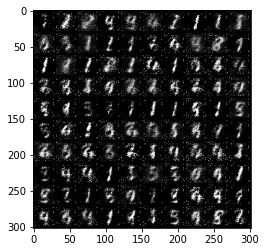

100%|██████████| 600/600 [00:17<00:00, 35.14it/s]


Epoch: 26/300, g_loss: 5.392789363861084, d_loss: 0.24115125834941864


100%|██████████| 600/600 [00:16<00:00, 36.12it/s]


Epoch: 27/300, g_loss: 4.565193176269531, d_loss: 0.288524329662323


100%|██████████| 600/600 [00:16<00:00, 35.84it/s]


Epoch: 28/300, g_loss: 4.348888397216797, d_loss: 0.3086816370487213


100%|██████████| 600/600 [00:16<00:00, 36.13it/s]


Epoch: 29/300, g_loss: 4.133501052856445, d_loss: 0.30148813128471375


100%|██████████| 600/600 [00:16<00:00, 35.64it/s]


Epoch: 30/300, g_loss: 4.017222881317139, d_loss: 0.3594547510147095


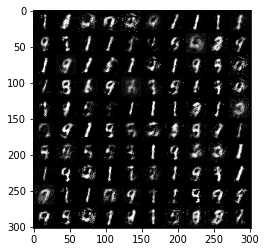

100%|██████████| 600/600 [00:16<00:00, 35.82it/s]


Epoch: 31/300, g_loss: 3.7878544330596924, d_loss: 0.40083974599838257


100%|██████████| 600/600 [00:16<00:00, 35.56it/s]


Epoch: 32/300, g_loss: 3.724553108215332, d_loss: 0.4001214802265167


100%|██████████| 600/600 [00:16<00:00, 36.03it/s]


Epoch: 33/300, g_loss: 3.822859287261963, d_loss: 0.3493465185165405


100%|██████████| 600/600 [00:16<00:00, 36.04it/s]


Epoch: 34/300, g_loss: 4.048916816711426, d_loss: 0.3383964002132416


100%|██████████| 600/600 [00:16<00:00, 35.77it/s]


Epoch: 35/300, g_loss: 4.509275913238525, d_loss: 0.3116942346096039


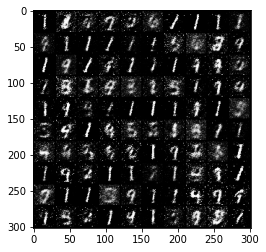

100%|██████████| 600/600 [00:16<00:00, 35.96it/s]


Epoch: 36/300, g_loss: 3.853654384613037, d_loss: 0.3725210130214691


100%|██████████| 600/600 [00:16<00:00, 35.86it/s]


Epoch: 37/300, g_loss: 3.4518730640411377, d_loss: 0.4098493456840515


100%|██████████| 600/600 [00:16<00:00, 35.46it/s]


Epoch: 38/300, g_loss: 3.386834144592285, d_loss: 0.43220746517181396


100%|██████████| 600/600 [00:16<00:00, 36.22it/s]


Epoch: 39/300, g_loss: 3.1020872592926025, d_loss: 0.4522448480129242


100%|██████████| 600/600 [00:16<00:00, 35.93it/s]


Epoch: 40/300, g_loss: 3.026261329650879, d_loss: 0.48445621132850647


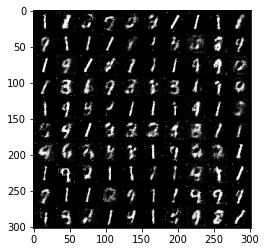

100%|██████████| 600/600 [00:16<00:00, 35.45it/s]


Epoch: 41/300, g_loss: 2.882659673690796, d_loss: 0.5051620602607727


100%|██████████| 600/600 [00:16<00:00, 36.04it/s]


Epoch: 42/300, g_loss: 2.904346466064453, d_loss: 0.5017012357711792


100%|██████████| 600/600 [00:16<00:00, 35.75it/s]


Epoch: 43/300, g_loss: 2.9459068775177, d_loss: 0.5018350481987


100%|██████████| 600/600 [00:16<00:00, 35.57it/s]


Epoch: 44/300, g_loss: 3.1972110271453857, d_loss: 0.46331483125686646


100%|██████████| 600/600 [00:16<00:00, 36.21it/s]


Epoch: 45/300, g_loss: 4.119078159332275, d_loss: 0.34460586309432983


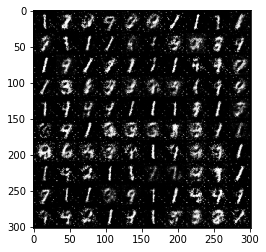

100%|██████████| 600/600 [00:17<00:00, 34.78it/s]


Epoch: 46/300, g_loss: 3.8939335346221924, d_loss: 0.3870753049850464


100%|██████████| 600/600 [00:16<00:00, 35.45it/s]


Epoch: 47/300, g_loss: 3.234943151473999, d_loss: 0.48141056299209595


100%|██████████| 600/600 [00:15<00:00, 39.09it/s]


Epoch: 48/300, g_loss: 2.827763557434082, d_loss: 0.5510137677192688


100%|██████████| 600/600 [00:15<00:00, 39.77it/s]


Epoch: 49/300, g_loss: 2.6720521450042725, d_loss: 0.5696436762809753


100%|██████████| 600/600 [00:15<00:00, 39.80it/s]


Epoch: 50/300, g_loss: 2.610793352127075, d_loss: 0.5934561491012573


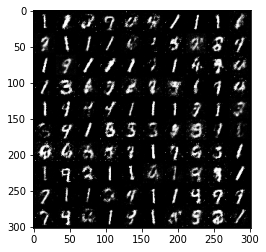

100%|██████████| 600/600 [00:15<00:00, 39.85it/s]


Epoch: 51/300, g_loss: 2.44476580619812, d_loss: 0.620851993560791


100%|██████████| 600/600 [00:15<00:00, 39.59it/s]


Epoch: 52/300, g_loss: 2.4376370906829834, d_loss: 0.6177774667739868


100%|██████████| 600/600 [00:14<00:00, 40.09it/s]


Epoch: 53/300, g_loss: 2.4411520957946777, d_loss: 0.630116879940033


100%|██████████| 600/600 [00:15<00:00, 39.99it/s]


Epoch: 54/300, g_loss: 2.580988645553589, d_loss: 0.5953542590141296


100%|██████████| 600/600 [00:15<00:00, 39.80it/s]


Epoch: 55/300, g_loss: 2.858949661254883, d_loss: 0.5405759215354919


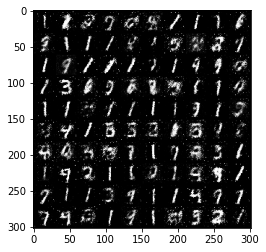

100%|██████████| 600/600 [00:15<00:00, 39.95it/s]


Epoch: 56/300, g_loss: 3.172283887863159, d_loss: 0.4930823743343353


100%|██████████| 600/600 [00:15<00:00, 39.24it/s]


Epoch: 57/300, g_loss: 3.253577470779419, d_loss: 0.46974316239356995


100%|██████████| 600/600 [00:14<00:00, 40.12it/s]


Epoch: 58/300, g_loss: 3.1332848072052, d_loss: 0.5159103870391846


100%|██████████| 600/600 [00:14<00:00, 40.30it/s]


Epoch: 59/300, g_loss: 2.7158796787261963, d_loss: 0.5882510542869568


100%|██████████| 600/600 [00:14<00:00, 40.10it/s]


Epoch: 60/300, g_loss: 2.5818655490875244, d_loss: 0.606577455997467


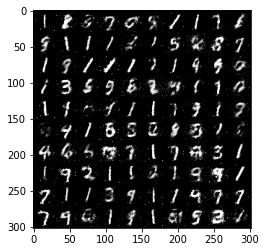

100%|██████████| 600/600 [00:14<00:00, 40.16it/s]


Epoch: 61/300, g_loss: 2.4859426021575928, d_loss: 0.6124261021614075


100%|██████████| 600/600 [00:14<00:00, 40.16it/s]


Epoch: 62/300, g_loss: 2.378709554672241, d_loss: 0.6354835033416748


100%|██████████| 600/600 [00:14<00:00, 40.25it/s]


Epoch: 63/300, g_loss: 2.3409712314605713, d_loss: 0.6152079701423645


100%|██████████| 600/600 [00:14<00:00, 40.32it/s]


Epoch: 64/300, g_loss: 2.3430960178375244, d_loss: 0.6434500217437744


100%|██████████| 600/600 [00:14<00:00, 40.06it/s]


Epoch: 65/300, g_loss: 2.3833436965942383, d_loss: 0.6395942568778992


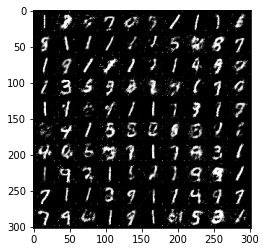

100%|██████████| 600/600 [00:15<00:00, 39.02it/s]


Epoch: 66/300, g_loss: 2.3909833431243896, d_loss: 0.6282863020896912


100%|██████████| 600/600 [00:15<00:00, 39.91it/s]


Epoch: 67/300, g_loss: 2.348980188369751, d_loss: 0.6348569989204407


100%|██████████| 600/600 [00:15<00:00, 39.88it/s]


Epoch: 68/300, g_loss: 2.4994125366210938, d_loss: 0.6230015158653259


100%|██████████| 600/600 [00:15<00:00, 39.96it/s]


Epoch: 69/300, g_loss: 2.649684429168701, d_loss: 0.5791703462600708


100%|██████████| 600/600 [00:14<00:00, 40.17it/s]


Epoch: 70/300, g_loss: 2.6625494956970215, d_loss: 0.5644612312316895


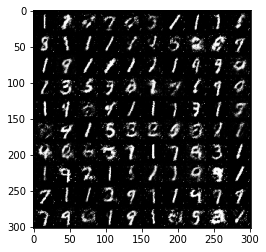

100%|██████████| 600/600 [00:15<00:00, 39.90it/s]


Epoch: 71/300, g_loss: 2.5493459701538086, d_loss: 0.6168498992919922


100%|██████████| 600/600 [00:14<00:00, 40.21it/s]


Epoch: 72/300, g_loss: 2.3656487464904785, d_loss: 0.6685289740562439


100%|██████████| 600/600 [00:14<00:00, 40.07it/s]


Epoch: 73/300, g_loss: 2.2950315475463867, d_loss: 0.66880202293396


100%|██████████| 600/600 [00:14<00:00, 40.34it/s]


Epoch: 74/300, g_loss: 2.278107166290283, d_loss: 0.6812595725059509


100%|██████████| 600/600 [00:14<00:00, 40.15it/s]


Epoch: 75/300, g_loss: 2.16359806060791, d_loss: 0.7052363157272339


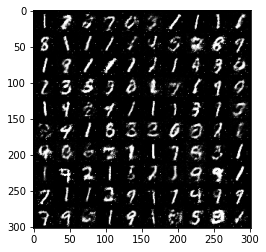

100%|██████████| 600/600 [00:15<00:00, 39.24it/s]


Epoch: 76/300, g_loss: 2.16983962059021, d_loss: 0.713904619216919


100%|██████████| 600/600 [00:14<00:00, 40.23it/s]


Epoch: 77/300, g_loss: 2.0963611602783203, d_loss: 0.7353606820106506


100%|██████████| 600/600 [00:14<00:00, 40.13it/s]


Epoch: 78/300, g_loss: 2.0340285301208496, d_loss: 0.7377619743347168


100%|██████████| 600/600 [00:15<00:00, 39.88it/s]


Epoch: 79/300, g_loss: 2.0930283069610596, d_loss: 0.7248547673225403


100%|██████████| 600/600 [00:14<00:00, 40.23it/s]


Epoch: 80/300, g_loss: 2.0746078491210938, d_loss: 0.7455555200576782


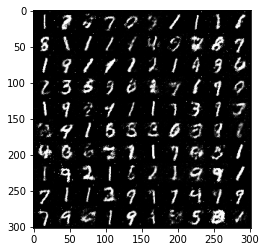

100%|██████████| 600/600 [00:15<00:00, 39.98it/s]


Epoch: 81/300, g_loss: 2.091691255569458, d_loss: 0.7407382726669312


100%|██████████| 600/600 [00:14<00:00, 40.05it/s]


Epoch: 82/300, g_loss: 2.0945634841918945, d_loss: 0.7442934513092041


100%|██████████| 600/600 [00:14<00:00, 40.14it/s]


Epoch: 83/300, g_loss: 2.1775710582733154, d_loss: 0.7222240567207336


100%|██████████| 600/600 [00:15<00:00, 39.09it/s]


Epoch: 84/300, g_loss: 2.152259588241577, d_loss: 0.7508715391159058


100%|██████████| 600/600 [00:14<00:00, 40.05it/s]


Epoch: 85/300, g_loss: 2.155240774154663, d_loss: 0.7269102931022644


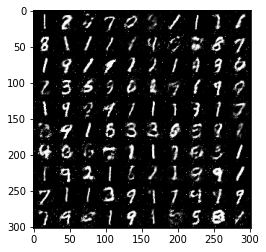

100%|██████████| 600/600 [00:15<00:00, 39.54it/s]


Epoch: 86/300, g_loss: 2.1912906169891357, d_loss: 0.7273600697517395


100%|██████████| 600/600 [00:14<00:00, 40.28it/s]


Epoch: 87/300, g_loss: 2.1272101402282715, d_loss: 0.7387844324111938


100%|██████████| 600/600 [00:15<00:00, 39.38it/s]


Epoch: 88/300, g_loss: 2.0891497135162354, d_loss: 0.7482345104217529


100%|██████████| 600/600 [00:14<00:00, 40.20it/s]


Epoch: 89/300, g_loss: 2.0985398292541504, d_loss: 0.7433804273605347


100%|██████████| 600/600 [00:14<00:00, 40.65it/s]


Epoch: 90/300, g_loss: 2.1612842082977295, d_loss: 0.7380878329277039


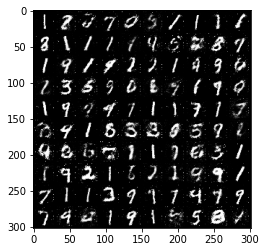

100%|██████████| 600/600 [00:14<00:00, 40.18it/s]


Epoch: 91/300, g_loss: 2.1184873580932617, d_loss: 0.7353017330169678


100%|██████████| 600/600 [00:14<00:00, 40.75it/s]


Epoch: 92/300, g_loss: 2.055237054824829, d_loss: 0.768722653388977


100%|██████████| 600/600 [00:14<00:00, 40.46it/s]


Epoch: 93/300, g_loss: 2.007066488265991, d_loss: 0.7575174570083618


100%|██████████| 600/600 [00:14<00:00, 40.67it/s]


Epoch: 94/300, g_loss: 1.9723381996154785, d_loss: 0.7764663696289062


100%|██████████| 600/600 [00:15<00:00, 39.81it/s]


Epoch: 95/300, g_loss: 2.0132510662078857, d_loss: 0.7662945985794067


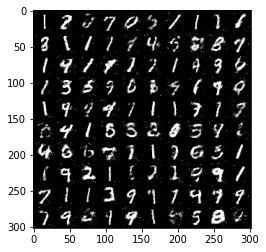

100%|██████████| 600/600 [00:14<00:00, 40.57it/s]


Epoch: 96/300, g_loss: 2.022394895553589, d_loss: 0.7819792628288269


100%|██████████| 600/600 [00:14<00:00, 40.44it/s]


Epoch: 97/300, g_loss: 1.9796271324157715, d_loss: 0.7784788608551025


100%|██████████| 600/600 [00:14<00:00, 40.67it/s]


Epoch: 98/300, g_loss: 1.968736171722412, d_loss: 0.7761456370353699


100%|██████████| 600/600 [00:14<00:00, 40.60it/s]


Epoch: 99/300, g_loss: 1.8931678533554077, d_loss: 0.8123336434364319


100%|██████████| 600/600 [00:14<00:00, 40.32it/s]


Epoch: 100/300, g_loss: 1.9467257261276245, d_loss: 0.7955194711685181


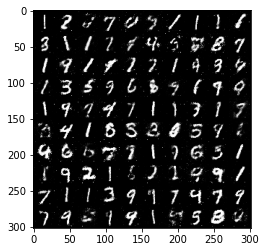

100%|██████████| 600/600 [00:14<00:00, 40.30it/s]


Epoch: 101/300, g_loss: 1.9067777395248413, d_loss: 0.8013743758201599


100%|██████████| 600/600 [00:14<00:00, 40.38it/s]


Epoch: 102/300, g_loss: 1.968963384628296, d_loss: 0.7975858449935913


100%|██████████| 600/600 [00:14<00:00, 40.29it/s]


Epoch: 103/300, g_loss: 1.8934992551803589, d_loss: 0.7949835658073425


100%|██████████| 600/600 [00:14<00:00, 40.52it/s]


Epoch: 104/300, g_loss: 2.0333409309387207, d_loss: 0.7779768705368042


100%|██████████| 600/600 [00:15<00:00, 39.99it/s]


Epoch: 105/300, g_loss: 1.8891761302947998, d_loss: 0.7877098917961121


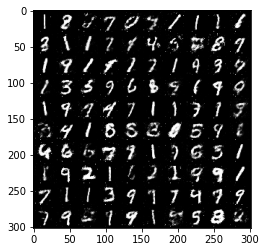

100%|██████████| 600/600 [00:14<00:00, 40.31it/s]


Epoch: 106/300, g_loss: 1.9793736934661865, d_loss: 0.7971968650817871


100%|██████████| 600/600 [00:14<00:00, 40.62it/s]


Epoch: 107/300, g_loss: 1.925452709197998, d_loss: 0.7873657941818237


100%|██████████| 600/600 [00:14<00:00, 40.13it/s]


Epoch: 108/300, g_loss: 1.9416404962539673, d_loss: 0.8029513359069824


100%|██████████| 600/600 [00:14<00:00, 40.59it/s]


Epoch: 109/300, g_loss: 1.9745001792907715, d_loss: 0.8094679713249207


100%|██████████| 600/600 [00:14<00:00, 40.63it/s]


Epoch: 110/300, g_loss: 1.8795002698898315, d_loss: 0.8063357472419739


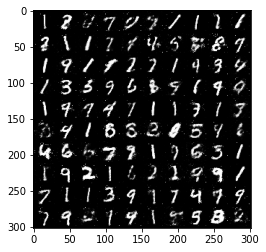

100%|██████████| 600/600 [00:15<00:00, 37.68it/s]


Epoch: 111/300, g_loss: 1.903441071510315, d_loss: 0.7962513566017151


100%|██████████| 600/600 [00:14<00:00, 40.66it/s]


Epoch: 112/300, g_loss: 1.8992087841033936, d_loss: 0.81416255235672


100%|██████████| 600/600 [00:14<00:00, 40.52it/s]


Epoch: 113/300, g_loss: 1.8818027973175049, d_loss: 0.8135442137718201


100%|██████████| 600/600 [00:14<00:00, 40.62it/s]


Epoch: 114/300, g_loss: 1.841871976852417, d_loss: 0.8268811106681824


100%|██████████| 600/600 [00:14<00:00, 40.48it/s]


Epoch: 115/300, g_loss: 1.8418725728988647, d_loss: 0.8358060717582703


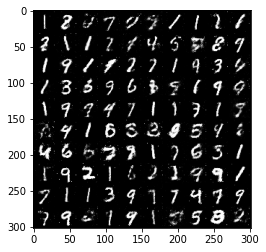

100%|██████████| 600/600 [00:14<00:00, 40.57it/s]


Epoch: 116/300, g_loss: 1.850509524345398, d_loss: 0.8237909078598022


100%|██████████| 600/600 [00:14<00:00, 40.51it/s]


Epoch: 117/300, g_loss: 1.8338950872421265, d_loss: 0.8340109586715698


100%|██████████| 600/600 [00:15<00:00, 39.99it/s]


Epoch: 118/300, g_loss: 1.7885165214538574, d_loss: 0.8433840870857239


100%|██████████| 600/600 [00:17<00:00, 34.73it/s]


Epoch: 119/300, g_loss: 1.7865489721298218, d_loss: 0.8367249369621277


100%|██████████| 600/600 [00:15<00:00, 39.75it/s]


Epoch: 120/300, g_loss: 1.7295633554458618, d_loss: 0.8417913317680359


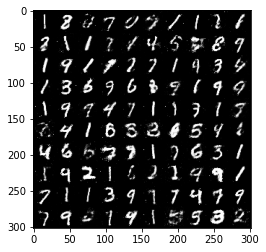

100%|██████████| 600/600 [00:14<00:00, 40.48it/s]


Epoch: 121/300, g_loss: 1.7956665754318237, d_loss: 0.8475301861763


100%|██████████| 600/600 [00:14<00:00, 40.29it/s]


Epoch: 122/300, g_loss: 1.8259303569793701, d_loss: 0.844088077545166


100%|██████████| 600/600 [00:14<00:00, 40.42it/s]


Epoch: 123/300, g_loss: 1.8121908903121948, d_loss: 0.8478134274482727


100%|██████████| 600/600 [00:14<00:00, 40.51it/s]


Epoch: 124/300, g_loss: 1.7569600343704224, d_loss: 0.8534358143806458


100%|██████████| 600/600 [00:14<00:00, 40.55it/s]


Epoch: 125/300, g_loss: 1.771360993385315, d_loss: 0.8666293621063232


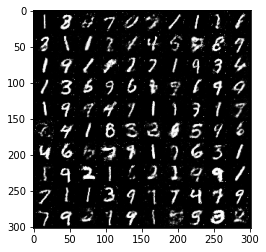

100%|██████████| 600/600 [00:15<00:00, 39.81it/s]


Epoch: 126/300, g_loss: 1.771270513534546, d_loss: 0.8606084585189819


100%|██████████| 600/600 [00:14<00:00, 40.12it/s]


Epoch: 127/300, g_loss: 1.7377116680145264, d_loss: 0.858066737651825


100%|██████████| 600/600 [00:14<00:00, 40.23it/s]


Epoch: 128/300, g_loss: 1.8101372718811035, d_loss: 0.8645309805870056


100%|██████████| 600/600 [00:14<00:00, 40.61it/s]


Epoch: 129/300, g_loss: 1.8085006475448608, d_loss: 0.8510924577713013


100%|██████████| 600/600 [00:14<00:00, 40.54it/s]


Epoch: 130/300, g_loss: 1.6990692615509033, d_loss: 0.868964672088623


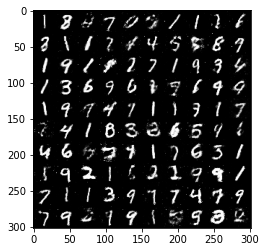

100%|██████████| 600/600 [00:15<00:00, 39.77it/s]


Epoch: 131/300, g_loss: 1.7396036386489868, d_loss: 0.8598090410232544


100%|██████████| 600/600 [00:15<00:00, 39.65it/s]


Epoch: 132/300, g_loss: 1.7584809064865112, d_loss: 0.8691097497940063


100%|██████████| 600/600 [00:14<00:00, 40.35it/s]


Epoch: 133/300, g_loss: 1.7678864002227783, d_loss: 0.8645690679550171


100%|██████████| 600/600 [00:14<00:00, 40.41it/s]


Epoch: 134/300, g_loss: 1.7094861268997192, d_loss: 0.8837900757789612


100%|██████████| 600/600 [00:14<00:00, 40.33it/s]


Epoch: 135/300, g_loss: 1.7293107509613037, d_loss: 0.8683147430419922


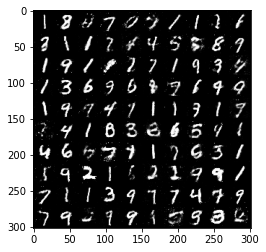

100%|██████████| 600/600 [00:15<00:00, 39.70it/s]


Epoch: 136/300, g_loss: 1.6790708303451538, d_loss: 0.8785541653633118


100%|██████████| 600/600 [00:14<00:00, 40.21it/s]


Epoch: 137/300, g_loss: 1.6996166706085205, d_loss: 0.8746220469474792


100%|██████████| 600/600 [00:14<00:00, 40.27it/s]


Epoch: 138/300, g_loss: 1.728261947631836, d_loss: 0.8793879151344299


100%|██████████| 600/600 [00:14<00:00, 40.23it/s]


Epoch: 139/300, g_loss: 1.6910334825515747, d_loss: 0.8867477178573608


100%|██████████| 600/600 [00:14<00:00, 40.33it/s]


Epoch: 140/300, g_loss: 1.6888059377670288, d_loss: 0.8755466341972351


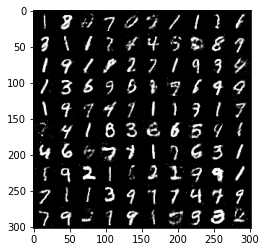

100%|██████████| 600/600 [00:15<00:00, 39.66it/s]


Epoch: 141/300, g_loss: 1.6590523719787598, d_loss: 0.8794143199920654


100%|██████████| 600/600 [00:14<00:00, 40.29it/s]


Epoch: 142/300, g_loss: 1.7422975301742554, d_loss: 0.8821150064468384


100%|██████████| 600/600 [00:15<00:00, 39.99it/s]


Epoch: 143/300, g_loss: 1.7439079284667969, d_loss: 0.8720669746398926


100%|██████████| 600/600 [00:14<00:00, 40.18it/s]


Epoch: 144/300, g_loss: 1.6984639167785645, d_loss: 0.8958556056022644


100%|██████████| 600/600 [00:14<00:00, 40.21it/s]


Epoch: 145/300, g_loss: 1.6804362535476685, d_loss: 0.8881240487098694


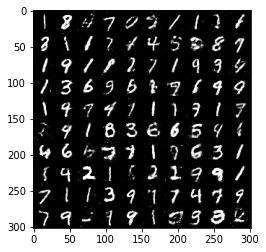

100%|██████████| 600/600 [00:14<00:00, 40.12it/s]


Epoch: 146/300, g_loss: 1.636367678642273, d_loss: 0.8910921216011047


100%|██████████| 600/600 [00:14<00:00, 40.24it/s]


Epoch: 147/300, g_loss: 1.7023723125457764, d_loss: 0.878132164478302


100%|██████████| 600/600 [00:15<00:00, 39.78it/s]


Epoch: 148/300, g_loss: 1.6648527383804321, d_loss: 0.9019659161567688


100%|██████████| 600/600 [00:14<00:00, 40.25it/s]


Epoch: 149/300, g_loss: 1.6628564596176147, d_loss: 0.8871217966079712


100%|██████████| 600/600 [00:15<00:00, 39.48it/s]


Epoch: 150/300, g_loss: 1.668687105178833, d_loss: 0.8948440551757812


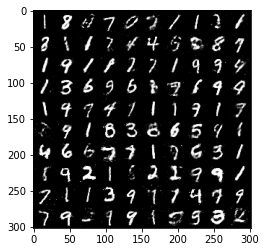

100%|██████████| 600/600 [00:15<00:00, 39.95it/s]


Epoch: 151/300, g_loss: 1.6365351676940918, d_loss: 0.892248272895813


100%|██████████| 600/600 [00:14<00:00, 40.06it/s]


Epoch: 152/300, g_loss: 1.6652112007141113, d_loss: 0.8953884243965149


100%|██████████| 600/600 [00:14<00:00, 40.24it/s]


Epoch: 153/300, g_loss: 1.6652741432189941, d_loss: 0.894287645816803


100%|██████████| 600/600 [00:14<00:00, 40.02it/s]


Epoch: 154/300, g_loss: 1.648162841796875, d_loss: 0.905163049697876


100%|██████████| 600/600 [00:14<00:00, 40.22it/s]


Epoch: 155/300, g_loss: 1.61016047000885, d_loss: 0.8941150307655334


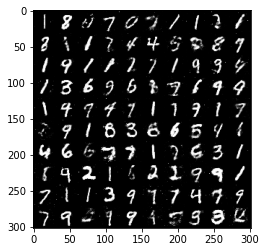

100%|██████████| 600/600 [00:15<00:00, 39.30it/s]


Epoch: 156/300, g_loss: 1.6319669485092163, d_loss: 0.8895100355148315


100%|██████████| 600/600 [00:14<00:00, 40.05it/s]


Epoch: 157/300, g_loss: 1.6177332401275635, d_loss: 0.9023534059524536


100%|██████████| 600/600 [00:14<00:00, 40.32it/s]


Epoch: 158/300, g_loss: 1.6404271125793457, d_loss: 0.8950015902519226


100%|██████████| 600/600 [00:14<00:00, 40.06it/s]


Epoch: 159/300, g_loss: 1.6767810583114624, d_loss: 0.8842591047286987


100%|██████████| 600/600 [00:14<00:00, 40.24it/s]


Epoch: 160/300, g_loss: 1.6660349369049072, d_loss: 0.8929921388626099


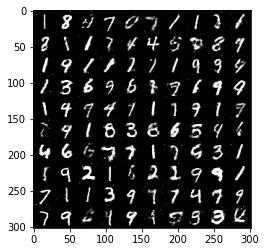

100%|██████████| 600/600 [00:15<00:00, 39.52it/s]


Epoch: 161/300, g_loss: 1.6468288898468018, d_loss: 0.8932039737701416


100%|██████████| 600/600 [00:14<00:00, 40.13it/s]


Epoch: 162/300, g_loss: 1.6122655868530273, d_loss: 0.8896721005439758


100%|██████████| 600/600 [00:15<00:00, 39.89it/s]


Epoch: 163/300, g_loss: 1.6459153890609741, d_loss: 0.8952622413635254


100%|██████████| 600/600 [00:14<00:00, 40.30it/s]


Epoch: 164/300, g_loss: 1.6519232988357544, d_loss: 0.8947727084159851


100%|██████████| 600/600 [00:14<00:00, 40.19it/s]


Epoch: 165/300, g_loss: 1.6276233196258545, d_loss: 0.9043329954147339


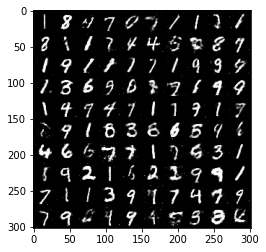

100%|██████████| 600/600 [00:15<00:00, 39.63it/s]


Epoch: 166/300, g_loss: 1.6139742136001587, d_loss: 0.8965671062469482


100%|██████████| 600/600 [00:14<00:00, 40.11it/s]


Epoch: 167/300, g_loss: 1.607747197151184, d_loss: 0.8983036875724792


100%|██████████| 600/600 [00:14<00:00, 40.12it/s]


Epoch: 168/300, g_loss: 1.6257742643356323, d_loss: 0.8987641930580139


100%|██████████| 600/600 [00:14<00:00, 40.21it/s]


Epoch: 169/300, g_loss: 1.5973137617111206, d_loss: 0.9060818552970886


100%|██████████| 600/600 [00:14<00:00, 40.13it/s]


Epoch: 170/300, g_loss: 1.6278586387634277, d_loss: 0.9039108753204346


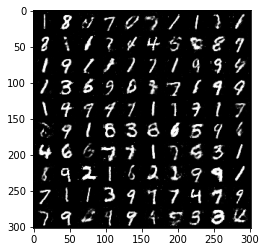

100%|██████████| 600/600 [00:15<00:00, 39.53it/s]


Epoch: 171/300, g_loss: 1.6207666397094727, d_loss: 0.8989678025245667


100%|██████████| 600/600 [00:15<00:00, 39.04it/s]


Epoch: 172/300, g_loss: 1.615310788154602, d_loss: 0.9088844060897827


100%|██████████| 600/600 [00:14<00:00, 40.09it/s]


Epoch: 173/300, g_loss: 1.5871878862380981, d_loss: 0.8984413146972656


100%|██████████| 600/600 [00:14<00:00, 40.05it/s]


Epoch: 174/300, g_loss: 1.6014678478240967, d_loss: 0.9113733172416687


100%|██████████| 600/600 [00:14<00:00, 40.13it/s]


Epoch: 175/300, g_loss: 1.6234967708587646, d_loss: 0.900780439376831


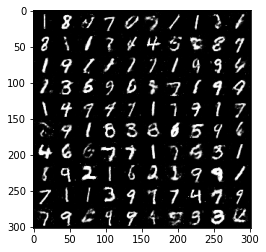

100%|██████████| 600/600 [00:15<00:00, 39.19it/s]


Epoch: 176/300, g_loss: 1.5710339546203613, d_loss: 0.9173784255981445


100%|██████████| 600/600 [00:14<00:00, 40.31it/s]


Epoch: 177/300, g_loss: 1.588570237159729, d_loss: 0.9154500961303711


100%|██████████| 600/600 [00:14<00:00, 40.24it/s]


Epoch: 178/300, g_loss: 1.607985258102417, d_loss: 0.900634765625


100%|██████████| 600/600 [00:15<00:00, 39.72it/s]


Epoch: 179/300, g_loss: 1.5879950523376465, d_loss: 0.916372537612915


100%|██████████| 600/600 [00:14<00:00, 40.35it/s]


Epoch: 180/300, g_loss: 1.562492847442627, d_loss: 0.9205464720726013


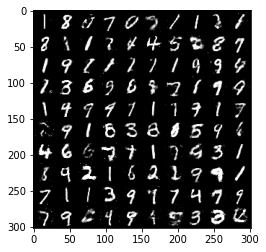

100%|██████████| 600/600 [00:15<00:00, 39.16it/s]


Epoch: 181/300, g_loss: 1.573807716369629, d_loss: 0.9234471917152405


100%|██████████| 600/600 [00:14<00:00, 40.31it/s]


Epoch: 182/300, g_loss: 1.58253812789917, d_loss: 0.9149531722068787


100%|██████████| 600/600 [00:15<00:00, 39.93it/s]


Epoch: 183/300, g_loss: 1.587878704071045, d_loss: 0.9115746021270752


100%|██████████| 600/600 [00:14<00:00, 40.38it/s]


Epoch: 184/300, g_loss: 1.6053959131240845, d_loss: 0.9115570783615112


100%|██████████| 600/600 [00:14<00:00, 40.18it/s]


Epoch: 185/300, g_loss: 1.6129118204116821, d_loss: 0.9144545197486877


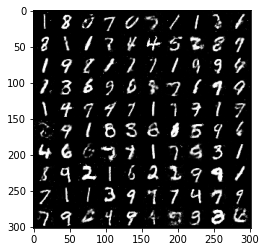

100%|██████████| 600/600 [00:15<00:00, 39.77it/s]


Epoch: 186/300, g_loss: 1.5577799081802368, d_loss: 0.921466588973999


100%|██████████| 600/600 [00:14<00:00, 40.06it/s]


Epoch: 187/300, g_loss: 1.550458312034607, d_loss: 0.9142971038818359


100%|██████████| 600/600 [00:15<00:00, 38.67it/s]


Epoch: 188/300, g_loss: 1.5914660692214966, d_loss: 0.9180687665939331


100%|██████████| 600/600 [00:14<00:00, 40.08it/s]


Epoch: 189/300, g_loss: 1.6104209423065186, d_loss: 0.9209640622138977


100%|██████████| 600/600 [00:15<00:00, 39.11it/s]


Epoch: 190/300, g_loss: 1.5645123720169067, d_loss: 0.9181497693061829


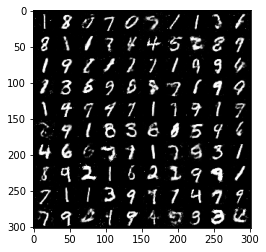

100%|██████████| 600/600 [00:15<00:00, 39.45it/s]


Epoch: 191/300, g_loss: 1.5581876039505005, d_loss: 0.9196106195449829


100%|██████████| 600/600 [00:15<00:00, 39.68it/s]


Epoch: 192/300, g_loss: 1.556268334388733, d_loss: 0.9193548560142517


100%|██████████| 600/600 [00:15<00:00, 39.54it/s]


Epoch: 193/300, g_loss: 1.5992032289505005, d_loss: 0.9285165071487427


100%|██████████| 600/600 [00:14<00:00, 40.06it/s]


Epoch: 194/300, g_loss: 1.5244086980819702, d_loss: 0.9201634526252747


100%|██████████| 600/600 [00:15<00:00, 38.67it/s]


Epoch: 195/300, g_loss: 1.5368891954421997, d_loss: 0.9185618162155151


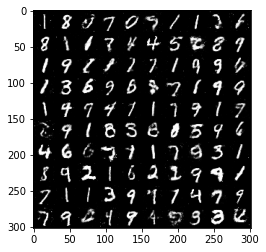

100%|██████████| 600/600 [00:15<00:00, 38.99it/s]


Epoch: 196/300, g_loss: 1.5558167695999146, d_loss: 0.9227726459503174


100%|██████████| 600/600 [00:15<00:00, 39.02it/s]


Epoch: 197/300, g_loss: 1.6166795492172241, d_loss: 0.9239020347595215


100%|██████████| 600/600 [00:15<00:00, 39.32it/s]


Epoch: 198/300, g_loss: 1.57781982421875, d_loss: 0.9245505928993225


100%|██████████| 600/600 [00:14<00:00, 40.20it/s]


Epoch: 199/300, g_loss: 1.5436382293701172, d_loss: 0.918311357498169


100%|██████████| 600/600 [00:14<00:00, 40.61it/s]


Epoch: 200/300, g_loss: 1.5583854913711548, d_loss: 0.9242004156112671


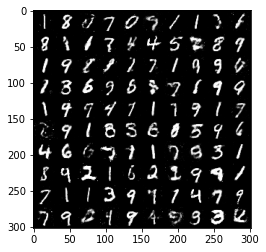

100%|██████████| 600/600 [00:15<00:00, 39.55it/s]


Epoch: 201/300, g_loss: 1.5680744647979736, d_loss: 0.9297268390655518


100%|██████████| 600/600 [00:14<00:00, 40.11it/s]


Epoch: 202/300, g_loss: 1.5480228662490845, d_loss: 0.9206035733222961


100%|██████████| 600/600 [00:14<00:00, 40.08it/s]


Epoch: 203/300, g_loss: 1.5617153644561768, d_loss: 0.9238499402999878


100%|██████████| 600/600 [00:14<00:00, 40.59it/s]


Epoch: 204/300, g_loss: 1.5218652486801147, d_loss: 0.9218446016311646


100%|██████████| 600/600 [00:14<00:00, 40.36it/s]


Epoch: 205/300, g_loss: 1.546096920967102, d_loss: 0.9294452667236328


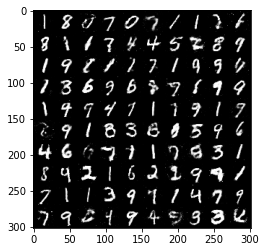

100%|██████████| 600/600 [00:15<00:00, 39.75it/s]


Epoch: 206/300, g_loss: 1.5790055990219116, d_loss: 0.9253202080726624


100%|██████████| 600/600 [00:14<00:00, 40.44it/s]


Epoch: 207/300, g_loss: 1.571600079536438, d_loss: 0.9259050488471985


100%|██████████| 600/600 [00:14<00:00, 40.61it/s]


Epoch: 208/300, g_loss: 1.5509309768676758, d_loss: 0.9265464544296265


100%|██████████| 600/600 [00:14<00:00, 40.51it/s]


Epoch: 209/300, g_loss: 1.5320602655410767, d_loss: 0.9275138974189758


100%|██████████| 600/600 [00:14<00:00, 40.60it/s]


Epoch: 210/300, g_loss: 1.5689287185668945, d_loss: 0.9268878102302551


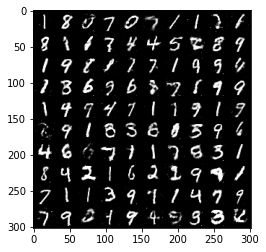

100%|██████████| 600/600 [00:15<00:00, 38.86it/s]


Epoch: 211/300, g_loss: 1.5265651941299438, d_loss: 0.9292396903038025


100%|██████████| 600/600 [00:14<00:00, 40.17it/s]


Epoch: 212/300, g_loss: 1.5270774364471436, d_loss: 0.9221572875976562


100%|██████████| 600/600 [00:14<00:00, 40.61it/s]


Epoch: 213/300, g_loss: 1.5297272205352783, d_loss: 0.9269702434539795


100%|██████████| 600/600 [00:14<00:00, 40.40it/s]


Epoch: 214/300, g_loss: 1.5489897727966309, d_loss: 0.9285967350006104


100%|██████████| 600/600 [00:14<00:00, 40.55it/s]


Epoch: 215/300, g_loss: 1.5698291063308716, d_loss: 0.9258716702461243


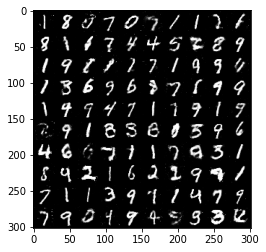

100%|██████████| 600/600 [00:15<00:00, 39.78it/s]


Epoch: 216/300, g_loss: 1.544488549232483, d_loss: 0.926788330078125


100%|██████████| 600/600 [00:14<00:00, 40.72it/s]


Epoch: 217/300, g_loss: 1.5370489358901978, d_loss: 0.9314634203910828


100%|██████████| 600/600 [00:14<00:00, 40.41it/s]


Epoch: 218/300, g_loss: 1.540773630142212, d_loss: 0.9326116442680359


100%|██████████| 600/600 [00:14<00:00, 40.69it/s]


Epoch: 219/300, g_loss: 1.5382208824157715, d_loss: 0.9273219108581543


100%|██████████| 600/600 [00:14<00:00, 40.63it/s]


Epoch: 220/300, g_loss: 1.529424786567688, d_loss: 0.9295847415924072


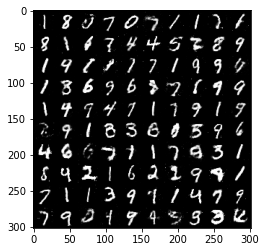

100%|██████████| 600/600 [00:15<00:00, 39.84it/s]


Epoch: 221/300, g_loss: 1.5607558488845825, d_loss: 0.9296588897705078


100%|██████████| 600/600 [00:14<00:00, 40.52it/s]


Epoch: 222/300, g_loss: 1.5774950981140137, d_loss: 0.9332025647163391


100%|██████████| 600/600 [00:14<00:00, 40.71it/s]


Epoch: 223/300, g_loss: 1.5244346857070923, d_loss: 0.9333385229110718


100%|██████████| 600/600 [00:14<00:00, 40.76it/s]


Epoch: 224/300, g_loss: 1.5457552671432495, d_loss: 0.9345545768737793


100%|██████████| 600/600 [00:14<00:00, 40.55it/s]


Epoch: 225/300, g_loss: 1.5427294969558716, d_loss: 0.9317783117294312


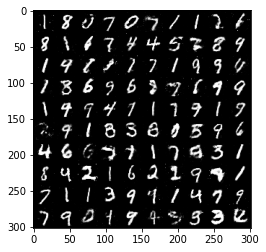

100%|██████████| 600/600 [00:15<00:00, 39.77it/s]


Epoch: 226/300, g_loss: 1.530642032623291, d_loss: 0.9336268305778503


100%|██████████| 600/600 [00:14<00:00, 40.50it/s]


Epoch: 227/300, g_loss: 1.5416008234024048, d_loss: 0.9357481598854065


100%|██████████| 600/600 [00:14<00:00, 40.76it/s]


Epoch: 228/300, g_loss: 1.5353868007659912, d_loss: 0.9333076477050781


100%|██████████| 600/600 [00:14<00:00, 40.78it/s]


Epoch: 229/300, g_loss: 1.5243316888809204, d_loss: 0.9352332949638367


100%|██████████| 600/600 [00:14<00:00, 40.96it/s]


Epoch: 230/300, g_loss: 1.5282988548278809, d_loss: 0.9280571341514587


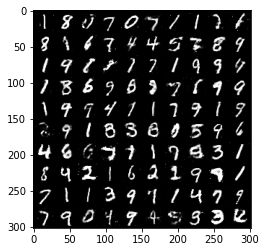

100%|██████████| 600/600 [00:15<00:00, 39.69it/s]


Epoch: 231/300, g_loss: 1.5420457124710083, d_loss: 0.9314435124397278


100%|██████████| 600/600 [00:14<00:00, 40.05it/s]


Epoch: 232/300, g_loss: 1.5457042455673218, d_loss: 0.9417473673820496


100%|██████████| 600/600 [00:14<00:00, 40.80it/s]


Epoch: 233/300, g_loss: 1.5301907062530518, d_loss: 0.9365856647491455


100%|██████████| 600/600 [00:14<00:00, 40.72it/s]


Epoch: 234/300, g_loss: 1.527385950088501, d_loss: 0.9304645657539368


100%|██████████| 600/600 [00:14<00:00, 40.61it/s]


Epoch: 235/300, g_loss: 1.531497836112976, d_loss: 0.9322039484977722


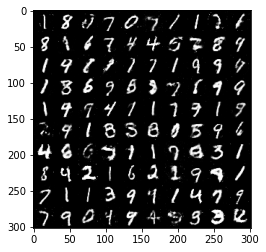

100%|██████████| 600/600 [00:14<00:00, 40.26it/s]


Epoch: 236/300, g_loss: 1.5199172496795654, d_loss: 0.9361104369163513


100%|██████████| 600/600 [00:14<00:00, 40.89it/s]


Epoch: 237/300, g_loss: 1.5394864082336426, d_loss: 0.9283176064491272


100%|██████████| 600/600 [00:14<00:00, 40.74it/s]


Epoch: 238/300, g_loss: 1.511499047279358, d_loss: 0.927202582359314


100%|██████████| 600/600 [00:14<00:00, 40.88it/s]


Epoch: 239/300, g_loss: 1.5141961574554443, d_loss: 0.9299904704093933


100%|██████████| 600/600 [00:14<00:00, 40.67it/s]


Epoch: 240/300, g_loss: 1.514617681503296, d_loss: 0.9345119595527649


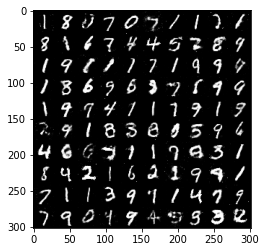

100%|██████████| 600/600 [00:14<00:00, 40.15it/s]


Epoch: 241/300, g_loss: 1.5385147333145142, d_loss: 0.9277783036231995


100%|██████████| 600/600 [00:14<00:00, 40.69it/s]


Epoch: 242/300, g_loss: 1.526666522026062, d_loss: 0.9381681084632874


100%|██████████| 600/600 [00:14<00:00, 40.90it/s]


Epoch: 243/300, g_loss: 1.5253570079803467, d_loss: 0.9248090982437134


100%|██████████| 600/600 [00:14<00:00, 40.89it/s]


Epoch: 244/300, g_loss: 1.5123530626296997, d_loss: 0.931850790977478


100%|██████████| 600/600 [00:14<00:00, 40.77it/s]


Epoch: 245/300, g_loss: 1.5364978313446045, d_loss: 0.9387540817260742


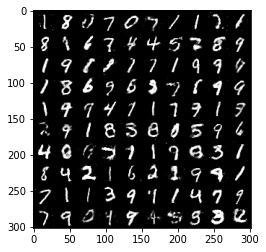

100%|██████████| 600/600 [00:14<00:00, 40.19it/s]


Epoch: 246/300, g_loss: 1.5233670473098755, d_loss: 0.9328395128250122


100%|██████████| 600/600 [00:14<00:00, 40.86it/s]


Epoch: 247/300, g_loss: 1.5056276321411133, d_loss: 0.935093104839325


100%|██████████| 600/600 [00:14<00:00, 40.89it/s]


Epoch: 248/300, g_loss: 1.540347695350647, d_loss: 0.9321155548095703


100%|██████████| 600/600 [00:14<00:00, 40.75it/s]


Epoch: 249/300, g_loss: 1.5264540910720825, d_loss: 0.9295265674591064


100%|██████████| 600/600 [00:14<00:00, 40.74it/s]


Epoch: 250/300, g_loss: 1.5285215377807617, d_loss: 0.9289180040359497


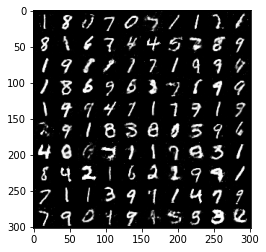

100%|██████████| 600/600 [00:14<00:00, 40.26it/s]


Epoch: 251/300, g_loss: 1.5389057397842407, d_loss: 0.9297385811805725


100%|██████████| 600/600 [00:15<00:00, 39.97it/s]


Epoch: 252/300, g_loss: 1.5400904417037964, d_loss: 0.9286566376686096


100%|██████████| 600/600 [00:14<00:00, 40.64it/s]


Epoch: 253/300, g_loss: 1.50593101978302, d_loss: 0.9297019839286804


100%|██████████| 600/600 [00:14<00:00, 40.86it/s]


Epoch: 254/300, g_loss: 1.5295838117599487, d_loss: 0.932422399520874


100%|██████████| 600/600 [00:14<00:00, 40.41it/s]


Epoch: 255/300, g_loss: 1.5171808004379272, d_loss: 0.9298311471939087


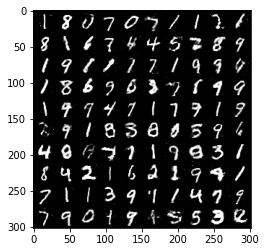

100%|██████████| 600/600 [00:14<00:00, 40.29it/s]


Epoch: 256/300, g_loss: 1.5125178098678589, d_loss: 0.9328166246414185


100%|██████████| 600/600 [00:14<00:00, 40.62it/s]


Epoch: 257/300, g_loss: 1.5154107809066772, d_loss: 0.9332209825515747


100%|██████████| 600/600 [00:14<00:00, 40.84it/s]


Epoch: 258/300, g_loss: 1.5449159145355225, d_loss: 0.9246728420257568


100%|██████████| 600/600 [00:14<00:00, 40.91it/s]


Epoch: 259/300, g_loss: 1.5307137966156006, d_loss: 0.9347902536392212


100%|██████████| 600/600 [00:14<00:00, 40.60it/s]


Epoch: 260/300, g_loss: 1.5454413890838623, d_loss: 0.930788516998291


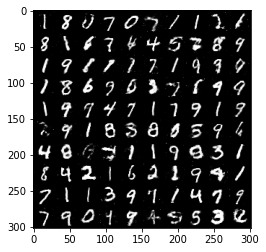

100%|██████████| 600/600 [00:14<00:00, 40.20it/s]


Epoch: 261/300, g_loss: 1.5355693101882935, d_loss: 0.9373334050178528


100%|██████████| 600/600 [00:14<00:00, 40.71it/s]


Epoch: 262/300, g_loss: 1.521051287651062, d_loss: 0.9276708364486694


100%|██████████| 600/600 [00:14<00:00, 40.62it/s]


Epoch: 263/300, g_loss: 1.5253829956054688, d_loss: 0.9270191192626953


100%|██████████| 600/600 [00:14<00:00, 40.71it/s]


Epoch: 264/300, g_loss: 1.5273869037628174, d_loss: 0.931149959564209


100%|██████████| 600/600 [00:14<00:00, 40.77it/s]


Epoch: 265/300, g_loss: 1.5612767934799194, d_loss: 0.9355838894844055


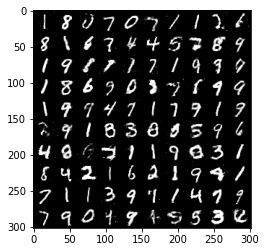

100%|██████████| 600/600 [00:14<00:00, 40.16it/s]


Epoch: 266/300, g_loss: 1.5166281461715698, d_loss: 0.9316800832748413


100%|██████████| 600/600 [00:14<00:00, 40.86it/s]


Epoch: 267/300, g_loss: 1.5288941860198975, d_loss: 0.9218250513076782


100%|██████████| 600/600 [00:14<00:00, 40.15it/s]


Epoch: 268/300, g_loss: 1.5167582035064697, d_loss: 0.9271097183227539


100%|██████████| 600/600 [00:14<00:00, 40.84it/s]


Epoch: 269/300, g_loss: 1.5054388046264648, d_loss: 0.9314778447151184


100%|██████████| 600/600 [00:14<00:00, 40.86it/s]


Epoch: 270/300, g_loss: 1.5617915391921997, d_loss: 0.9290335178375244


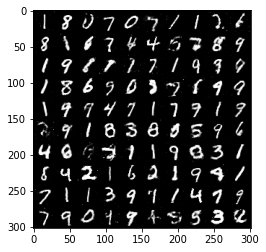

100%|██████████| 600/600 [00:14<00:00, 40.20it/s]


Epoch: 271/300, g_loss: 1.491978406906128, d_loss: 0.93092942237854


100%|██████████| 600/600 [00:14<00:00, 40.73it/s]


Epoch: 272/300, g_loss: 1.4995543956756592, d_loss: 0.9290485382080078


100%|██████████| 600/600 [00:14<00:00, 40.77it/s]


Epoch: 273/300, g_loss: 1.5395216941833496, d_loss: 0.9320771098136902


100%|██████████| 600/600 [00:14<00:00, 40.88it/s]


Epoch: 274/300, g_loss: 1.5541071891784668, d_loss: 0.9282722473144531


100%|██████████| 600/600 [00:14<00:00, 40.76it/s]


Epoch: 275/300, g_loss: 1.521937370300293, d_loss: 0.9293156862258911


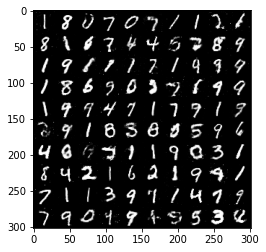

100%|██████████| 600/600 [00:14<00:00, 40.15it/s]


Epoch: 276/300, g_loss: 1.5332119464874268, d_loss: 0.9266577363014221


100%|██████████| 600/600 [00:14<00:00, 40.72it/s]


Epoch: 277/300, g_loss: 1.5725398063659668, d_loss: 0.932925283908844


100%|██████████| 600/600 [00:14<00:00, 40.95it/s]


Epoch: 278/300, g_loss: 1.5088475942611694, d_loss: 0.9322220683097839


100%|██████████| 600/600 [00:14<00:00, 40.75it/s]


Epoch: 279/300, g_loss: 1.5245999097824097, d_loss: 0.9321600794792175


100%|██████████| 600/600 [00:14<00:00, 40.87it/s]


Epoch: 280/300, g_loss: 1.5290864706039429, d_loss: 0.9269177913665771


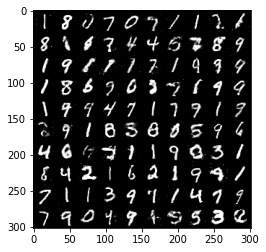

100%|██████████| 600/600 [00:14<00:00, 40.01it/s]


Epoch: 281/300, g_loss: 1.5126010179519653, d_loss: 0.9247201085090637


100%|██████████| 600/600 [00:14<00:00, 40.76it/s]


Epoch: 282/300, g_loss: 1.524728536605835, d_loss: 0.9324068427085876


100%|██████████| 600/600 [00:14<00:00, 40.87it/s]


Epoch: 283/300, g_loss: 1.5231084823608398, d_loss: 0.9208455681800842


100%|██████████| 600/600 [00:14<00:00, 40.80it/s]


Epoch: 284/300, g_loss: 1.5697579383850098, d_loss: 0.9236915707588196


100%|██████████| 600/600 [00:14<00:00, 40.83it/s]


Epoch: 285/300, g_loss: 1.5231627225875854, d_loss: 0.9243097901344299


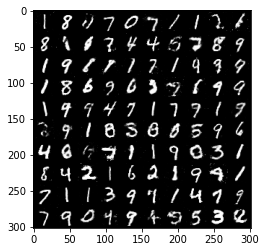

100%|██████████| 600/600 [00:14<00:00, 40.20it/s]


Epoch: 286/300, g_loss: 1.5262354612350464, d_loss: 0.9245403409004211


100%|██████████| 600/600 [00:14<00:00, 40.62it/s]


Epoch: 287/300, g_loss: 1.5304670333862305, d_loss: 0.929098904132843


100%|██████████| 600/600 [00:14<00:00, 40.02it/s]


Epoch: 288/300, g_loss: 1.513038992881775, d_loss: 0.9260718822479248


100%|██████████| 600/600 [00:14<00:00, 40.44it/s]


Epoch: 289/300, g_loss: 1.5601184368133545, d_loss: 0.936224639415741


100%|██████████| 600/600 [00:14<00:00, 40.74it/s]


Epoch: 290/300, g_loss: 1.5291917324066162, d_loss: 0.924177885055542


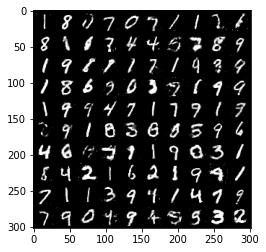

100%|██████████| 600/600 [00:14<00:00, 40.24it/s]


Epoch: 291/300, g_loss: 1.5376943349838257, d_loss: 0.9233459234237671


100%|██████████| 600/600 [00:14<00:00, 40.87it/s]


Epoch: 292/300, g_loss: 1.5348289012908936, d_loss: 0.9266861081123352


100%|██████████| 600/600 [00:14<00:00, 40.62it/s]


Epoch: 293/300, g_loss: 1.5440524816513062, d_loss: 0.9272633790969849


100%|██████████| 600/600 [00:14<00:00, 40.80it/s]


Epoch: 294/300, g_loss: 1.538017988204956, d_loss: 0.9231314063072205


100%|██████████| 600/600 [00:14<00:00, 40.76it/s]


Epoch: 295/300, g_loss: 1.5257664918899536, d_loss: 0.9211920499801636


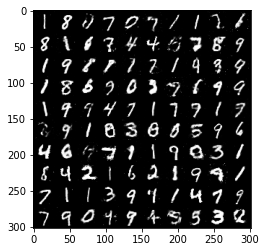

100%|██████████| 600/600 [00:14<00:00, 40.22it/s]


Epoch: 296/300, g_loss: 1.5212730169296265, d_loss: 0.9269518256187439


100%|██████████| 600/600 [00:14<00:00, 40.58it/s]


Epoch: 297/300, g_loss: 1.5359463691711426, d_loss: 0.9226146340370178


100%|██████████| 600/600 [00:14<00:00, 40.87it/s]


Epoch: 298/300, g_loss: 1.5341600179672241, d_loss: 0.91902095079422


100%|██████████| 600/600 [00:14<00:00, 40.71it/s]


Epoch: 299/300, g_loss: 1.5349866151809692, d_loss: 0.9230635166168213


100%|██████████| 600/600 [00:14<00:00, 40.86it/s]


Epoch: 300/300, g_loss: 1.5328352451324463, d_loss: 0.9167704582214355


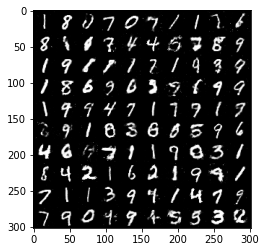

In [17]:
for epoch in range(1, epochs+1):
    mean_g_loss = 0
    mean_d_loss = 0
    for img, _ in tqdm(trainloader):
        #img: [batch_size, 1, 28, 28]
        img = img.view(img.shape[0], -1).to(device)
        #img: [batch_size, 784]
        
        d_loss = train_discriminator(img, img.shape[0])
        g_loss = train_generator(img.shape[0])

        #Stats
        mean_d_loss += d_loss / len(trainloader)
        mean_g_loss += g_loss / len(trainloader)
    
    #Verbose
    print(f"Epoch: {epoch}/{epochs}, g_loss: {mean_g_loss}, d_loss: {mean_d_loss}")
    
    save_fake_images(epoch)
    if (epoch % 5) == 0:
        img = plt.imread(os.path.join(output_dir, "fake_images-{0:0=4d}.png".format(epoch)))
        plt.imshow(img, cmap='gray')
        plt.show()

## Saving

In [18]:
#Save the model checkpoints 
torch.save(generator.state_dict(), 'generator.pt')
torch.save(discriminator.state_dict(), 'discriminator.pt')

In [4]:
#Make gif
import glob
from PIL import Image

def make_gif(img_filename, gif_filename):
    img, *imgs = [Image.open(f) for f in sorted(glob.glob(img_filename))]
    img.save(fp=gif_filename, format='GIF', append_images=imgs,
         save_all=True, duration=100, loop=0)

img_filename = os.path.join(output_dir, "fake_images-*.png")
gif_filename = os.path.join(output_dir, "mnist_basic_gan_trainig.gif")
make_gif(img_filename, gif_filename)

In [20]:
#Make video
import cv2
import os
from IPython.display import FileLink

video_filename = os.path.join(output_dir, "mnist_basic_gan_trainig.avi")
frame_size = (302,302) #img shape

out = cv2.VideoWriter(video_filename, cv2.VideoWriter_fourcc(*'DIVX'), 16, frame_size)

files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if 'fake_images' in f]
files.sort()

for fname in files:
    img = cv2.imread(fname)
    out.write(img)

out.release()

## Testing

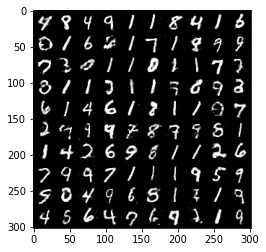

In [32]:
from torchvision.utils import make_grid

#Load saved model
generator = Generator(input_size=64, output_size=784, hidden_size=256)
generator.load_state_dict(torch.load('generator.pt'))
generator.eval()

#Generate fake image from noise vector
noise_vector = noise_generator(100, latent_size)
fake_img = generator(noise_vector)

fake_img = denormalize(fake_img.detach().cpu().view(-1, 1, 28, 28))
fake_img = make_grid(tensor=fake_img, nrow=10).permute(1,2,0)
#fake_img: [h,w,c], just one img

plt.imshow(fake_img, cmap='gray')
plt.show()

## References

* Generative Adversarial Nets [Goodfellow et al., 2014]: https://arxiv.org/pdf/1406.2661.pdf
* https://www.kaggle.com/kmldas/mnist-generative-adverserial-networks-in-pytorch